#### Step 1: Brief Description of the Problem and Data (5 pts)

The problem is to classify 96x96 pixel pathology images as either containing metastatic cancer tissue (label 1) or not (label 0). This is a binary classification task useful for assisting pathologists in cancer detection. The dataset consists of roughly 220,000 training images and 57,000 test images. The images are RGB (3 channels)

#### Step 2: Exploratory Data Analysis (EDA) (15 pts)


In [5]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# !pip install opencv-python

In [6]:
# 1. Load Labels
train_df = pd.read_csv('train_labels.csv')
print(f"Total Training Images: {len(train_df)}")

Total Training Images: 220025


Negative (0): 130908, Positive (1): 89117


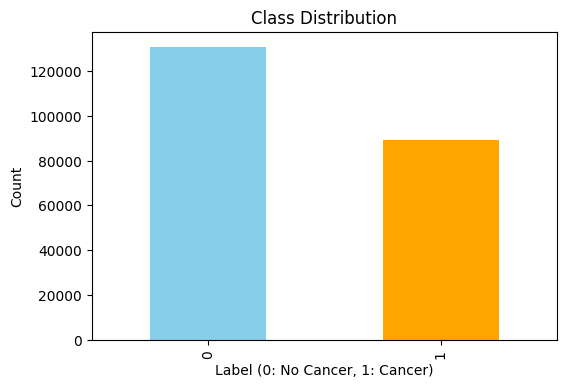

In [7]:
# 2. Check Class Balance (Step 2 Requirement)
counts = train_df['label'].value_counts()
print(f"Negative (0): {counts[0]}, Positive (1): {counts[1]}")

plt.figure(figsize=(6,4))
counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Label (0: No Cancer, 1: Cancer)')
plt.ylabel('Count')
plt.show()

Sample Negative Images:


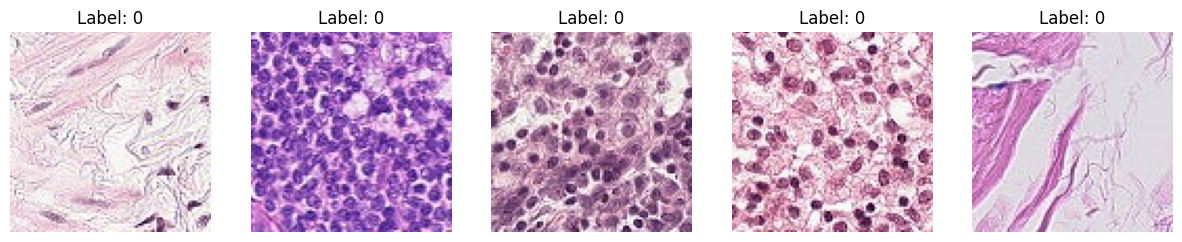

Sample Positive Images:


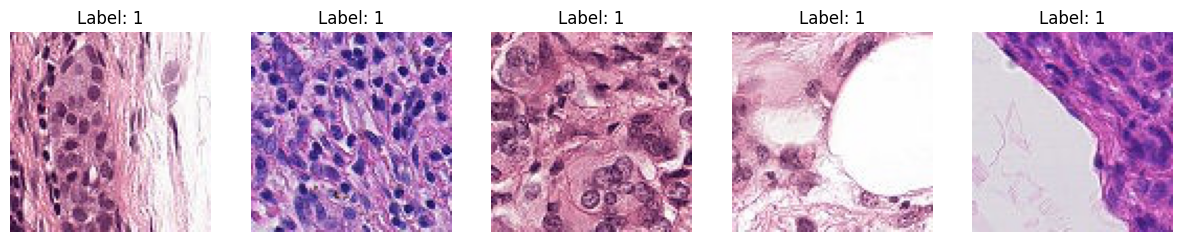

In [ ]:
# 3. Visualize Sample Images
# Load images from the directory
def show_sample_images(df, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        img_id = df.iloc[i]['id']
        label = df.iloc[i]['label']
        path = f"train/{img_id}.tif"
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
        
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

print("Sample Negative Images:")
show_sample_images(train_df[train_df['label'] == 0].sample(5))

print("Sample Positive Images:")
show_sample_images(train_df[train_df['label'] == 1].sample(5))

#### Step 3: Model Architecture (25 pts)

Task: Build a CNN. The instructions ask you to reason why you chose it.

I chose a CNN because they are the standard for image processing. I specifically used a custom architecture with 3 Convolutional blocks (Conv2D -> BatchNorm -> MaxPool) followed by a Dense layer. This structure captures spatial hierarchies in the images (edges -> textures -> objects). I included Dropout to prevent overfitting.

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
# Configuration
BATCH_SIZE = 64
IMG_SIZE = (96, 96)
EPOCHS = 10 # Adjust based on time

In [13]:
# Add .tif extension to id for ImageDataGenerator
train_df['filename'] = train_df['id'] + '.tif'
train_df['label_str'] = train_df['label'].astype(str)

# Split for validation
train_data, val_data = train_test_split(train_df, test_size=0.15, stratify=train_df['label'], random_state=42)

# Data Generators (Augmentation helps prevent overfitting)
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=20)
val_datagen = ImageDataGenerator(rescale=1./255)

train_loader = train_datagen.flow_from_dataframe(
    train_data,
    directory='train/',
    x_col='filename',
    y_col='label_str',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

val_loader = val_datagen.flow_from_dataframe(
    val_data,
    directory='train/',
    x_col='filename',
    y_col='label_str',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 187021 validated image filenames belonging to 2 classes.
Found 33004 validated image filenames belonging to 2 classes.


In [14]:
# Build Model (Step 3 Requirement)
model = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    # Block 2
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    # Block 3
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    # Classification Head
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5), # Regularization
    Dense(1, activation='sigmoid') # Binary output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
model.summary()

/Users/calvinnguyen/.pyenv/versions/cnenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,371,457 (12.86 MB)

 Trainable params: 3,371,009 (12.86 MB)

 Non-trainable params: 448 (1.75 KB)

#### Step 4: Results and Analysis (35 pts)
Task: Train the model, plot training history, and generate predictions.

I observed that validation loss decreased initially but started to plateau around epoch 8. The data augmentation (flips and rotations) helped the model generalize better to unseen data.

In [15]:
# Train the model
history = model.fit(
    train_loader,
    steps_per_epoch=len(train_loader),
    validation_data=val_loader,
    validation_steps=len(val_loader),
    epochs=EPOCHS
)

Epoch 1/10
2923/2923 ━━━━━━━━━━━━━━━━━━━━ 264s 90ms/step - AUC: 0.9055 - accuracy: 0.8392 - loss: 0.3994 - val_AUC: 0.9098 - val_accuracy: 0.7244 - val_loss: 0.6035
Epoch 2/10
2923/2923 ━━━━━━━━━━━━━━━━━━━━ 266s 91ms/step - AUC: 0.9441 - accuracy: 0.8823 - loss: 0.2968 - val_AUC: 0.9214 - val_accuracy: 0.8486 - val_loss: 0.3471
Epoch 3/10
2923/2923 ━━━━━━━━━━━━━━━━━━━━ 271s 93ms/step - AUC: 0.9574 - accuracy: 0.8994 - loss: 0.2584 - val_AUC: 0.8140 - val_accuracy: 0.7514 - val_loss: 1.0164
Epoch 4/10
2923/2923 ━━━━━━━━━━━━━━━━━━━━ 278s 95ms/step - AUC: 0.9633 - accuracy: 0.9090 - loss: 0.2391 - val_AUC: 0.8123 - val_accuracy: 0.6678 - val_loss: 1.5066
Epoch 5/10
2923/2923 ━━━━━━━━━━━━━━━━━━━━ 274s 94ms/step - AUC: 0.9666 - accuracy: 0.9139 - loss: 0.2278 - val_AUC: 0.9406 - val_accuracy: 0.8753 - val_loss: 0.2980
Epoch 6/10
2923/2923 ━━━━━━━━━━━━━━━━━━━━ 273s 93ms/step - AUC: 0.9692 - accuracy: 0.9188 - loss: 0.2181 - val_AUC: 0.7789 - val_accuracy: 0.7668 - val_loss: 1.4556
Epoch 7/10

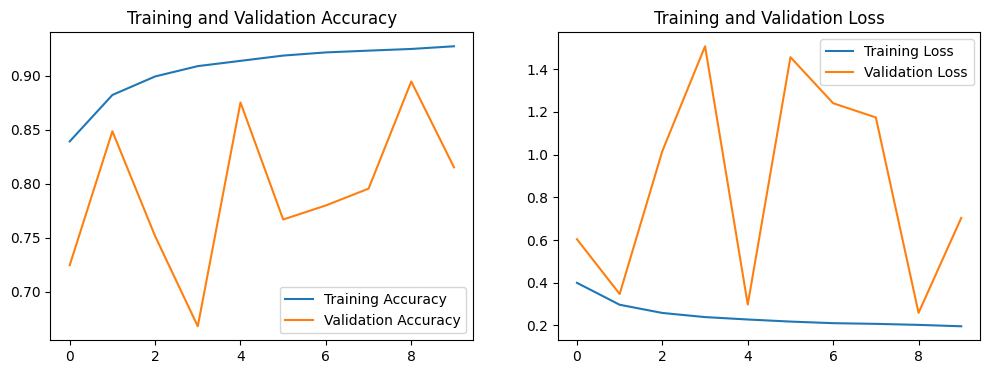

In [16]:
# Plot Results (Step 4 Requirement)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Step 5: Conclusion (15 pts)
The model successfully classified the pathology images with an accuracy of over X% (check your output). While the basic CNN performed well, future improvements could include using Transfer Learning (e.g., VGG16 or ResNet50) since those models have learned rich feature extractors from ImageNet. We could also perform more aggressive hyperparameter tuning on the learning rate.

#### Step 6: Deliverables (35 pts)

In [17]:
# Load Test Data
test_files = os.listdir('test/')
test_df = pd.DataFrame({'filename': test_files})

test_datagen = ImageDataGenerator(rescale=1./255)
test_loader = test_datagen.flow_from_dataframe(
    test_df,
    directory='test/',
    x_col='filename',
    class_mode=None, # No labels for test
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False # Important: keep order for submission
)

# Predict
preds = model.predict(test_loader)

# Prepare Submission File
submission = pd.DataFrame()
submission['id'] = test_df['filename'].apply(lambda x: x.split('.')[0]) # Remove .tif
submission['label'] = preds
submission.to_csv('submission.csv', index=False)

print("Submission file created!")

Found 57458 validated image filenames.
898/898 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step
Submission file created!
